<a href="https://colab.research.google.com/github/andrewgray11/msdscapstone/blob/main/Solar_Power_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

pd.set_option('display.width', 1000)

In [ ]:
# Load the dataset
df = pd.read_csv('updated_Pasion.csv')

# Data Preparation

## Adding State Data

In [ ]:
# create a dictionary to map location names to states
states = {
    'Camp Murray': 'WA',
    'Grissom': 'IN',
    'Hill Weber': 'UT',
    'JDMT': 'FL',
    'Kahului': 'HI',
    'Malmstrom': 'MT',
    'March AFB': 'CA',
    'MNANG': 'MN',
    'Offutt': 'IA',
    'Peterson': 'CO',
    'Travis': 'CA',
    'USAFA': 'CO'
}

# add a column with the corresponding state for each location name
df['State'] = df['Location Name'].map(states)

df.head()

,Location Name,Date_x,Time_x,Latitude,Longitude,Location,Altitude,YRMODAHRMI,Month,Hour,...,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily,Date_y,Time_y,State
0,Grissom,20181004,1030,40.67,-86.15,40.67_-86.15_20181004_1030,239,2.018100e+11,10,10,...,88.5,0.0,985.1,242,5.2,106,0.19,20181004,1030,IN
1,Grissom,20181004,1100,40.67,-86.15,40.67_-86.15_20181004_1100,239,2.018100e+11,10,11,...,89.4,0.0,985.8,246,5.0,100,0.19,20181004,1100,IN
2,Grissom,20181004,1300,40.67,-86.15,40.67_-86.15_20181004_1300,239,2.018100e+11,10,13,...,94.2,0.0,987.7,291,4.3,78,0.19,20181004,1300,IN
3,Grissom,20181004,1330,40.67,-86.15,40.67_-86.15_20181004_1330,239,2.018100e+11,10,13,...,91.3,0.0,988.3,313,4.6,72,0.19,20181004,1330,IN
4,Hill Weber,20181004,1000,41.15,-111.99,41.15_-111.99_20181004_1000,1370,2.018100e+11,10,10,...,90.6,0.0,875.5,87,0.8,129,0.15,20181004,1000,UT


## Feature Encoding

In [ ]:
# Encode seasons
le = LabelEncoder()
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
le.fit(seasons)
df['Season_Encoded'] = le.transform(df['Season'])

# Create mapping dictionary
mapping_season = dict(zip(range(len(le.classes_)), le.classes_))
print(mapping_season)

{0: 'Fall', 1: 'Spring', 2: 'Summer', 3: 'Winter'}


In [ ]:
# Encode locations
le2 = LabelEncoder()
le2.fit(df['Location Name'])
df['Location_Encoded'] = le2.transform(df['Location Name'])

# Create mapping dictionary
mapping_loc = dict(zip(range(len(le2.classes_)), le2.classes_))

In [ ]:
# assign X and y for explanatory and target variables
X = df.drop('PolyPwr', axis=1)
y = df['PolyPwr']

# Train Test Split (all features)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['Location Name', 'Location', 'Date_y', 'Time_y', 'YRMODAHRMI', 'Season', 'State', 'Date_x', 'Time_x', 'Latitude', 'Longitude', 'Month', 'Hour', 'Cloud.Ceiling', 'Visibility', 'Dhi', 'Dni']
X_train_red = X_train.drop(columns_to_drop, axis=1)
X_test_red = X_test.drop(columns_to_drop, axis=1)

In [ ]:
X_train_red.head()

,Altitude,Humidity,AmbientTemp,Wind.Speed,Pressure,AirTemp,Azimuth,CloudOpacity,DewpointTemp,Ebh,...,PrecipitableWater,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily,Season_Encoded,Location_Encoded
3048,458,19.04907,42.54784,6,959.8,24.3,-57,0.0,14.1,0,...,47.2,53.1,0.0,974.4,78,0.7,103,0.15,2,7
16665,458,2.60620,30.35713,22,958.5,13.1,-97,0.0,0.2,1,...,7.4,41.0,0.0,971.3,51,2.8,90,0.16,0,7
9792,1947,33.61206,9.73717,17,797.6,-1.3,-64,0.0,-3.6,0,...,5.6,84.2,0.9,790.6,11,1.6,111,0.17,1,11
3753,1947,7.84302,49.04099,7,802.6,25.3,-89,52.3,4.6,0,...,15.5,26.3,0.0,804.7,303,2.4,57,0.15,2,11
7270,1043,48.59009,16.82953,0,900.0,7.8,-82,40.3,4.9,0,...,16.7,81.4,0.0,917.5,80,4.5,71,0.18,1,6


In [ ]:
X_train_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16836 entries, 3048 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Altitude           16836 non-null  int64  
 1   Humidity           16836 non-null  float64
 2   AmbientTemp        16836 non-null  float64
 3   Wind.Speed         16836 non-null  int64  
 4   Pressure           16836 non-null  float64
 5   AirTemp            16836 non-null  float64
 6   Azimuth            16836 non-null  int64  
 7   CloudOpacity       16836 non-null  float64
 8   DewpointTemp       16836 non-null  float64
 9   Ebh                16836 non-null  int64  
 10  Ghi                16836 non-null  int64  
 11  GtiFixedTilt       16836 non-null  int64  
 12  GtiTracking        16836 non-null  int64  
 13  PrecipitableWater  16836 non-null  float64
 14  RelativeHumidity   16836 non-null  float64
 15  SnowWater          16836 non-null  float64
 16  SurfacePressure    

# Models (all features)

## Random Forest by Season

In [ ]:
# Create a dictionary to store the models for each season
season_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each season
for season_code, season_name in mapping_season.items():
    # Filter the data for the current season
    season_X_train = X_train_red[X_train_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis =1)
    season_y_train = y_train[X_train_red['Season_Encoded'] == season_code]
    season_X_test = X_test_red[X_test_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis =1)
    season_y_test = y_test[X_test_red['Season_Encoded'] == season_code]
    
    # Create a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(season_X_train, season_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(season_X_test)
    test_score = model.score(season_X_test, season_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(season_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(season_X_train)

    # Calculate the R^2 score on the training data
    train_score = model.score(season_X_train, season_y_train)

    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(season_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    season_models[season_name] = model
    
    # Make predictions on the full dataset
    season_X_full = X[X['Season_Encoded'] == season_code].drop(columns_to_drop, axis=1).drop(['Location_Encoded'], axis =1)
    season_y_full = y[X['Season_Encoded'] == season_code]
    full_predictions = model.predict(season_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(season_y_full, full_predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(season_y_full, full_predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Season': season_name,
                    'R^2 Score (Train Data)': train_score,
                    'RMSE (Train Data)': train_rmse,
                    'R^2 Score (Test Data)': test_score,
                    'RMSE (Test Data)': test_rmse,
                    'R^2 Score (Full Data)': full_data_score,
                    'RMSE (Full Data)': full_rmse})
                    

# Create a DataFrame from the scores list
scores_df = pd.DataFrame(scores_list)

# Accessing the models for each season
spring_model = season_models['Spring']
summer_model = season_models['Summer']
fall_model = season_models['Fall']
winter_model = season_models['Winter']

In [ ]:
# Print the scores table
print('Random Forest by Season Results:')
print(scores_df)

Random Forest by Season Results:
   Season  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0    Fall                0.949175           1.378852               0.678027          3.509986               0.893519          2.000738
1  Spring                0.937504           1.902210               0.582885          4.860038               0.866967          2.769531
2  Summer                0.941390           1.577443               0.611408          4.038443               0.876344          2.288664
3  Winter                0.964738           1.121549               0.755816          3.003006               0.922474          1.668976


## Extra Trees by Season

In [ ]:
# Create a dictionary to store the models for each season
season_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each season
for season_code, season_name in mapping_season.items():
    # Filter the data for the current season
    season_X_train = X_train_red[X_train_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis =1)
    season_y_train = y_train[X_train_red['Season_Encoded'] == season_code]
    season_X_test = X_test_red[X_test_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis =1)
    season_y_test = y_test[X_test_red['Season_Encoded'] == season_code]
    
    # Create a ExtraTrees model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(season_X_train, season_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(season_X_test)
    test_score = model.score(season_X_test, season_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(season_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(season_X_train)

    # Calculate the R^2 score on the training data
    train_score = model.score(season_X_train, season_y_train)

    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(season_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    season_models[season_name] = model
    
    # Make predictions on the full dataset
    season_X_full = X[X['Season_Encoded'] == season_code].drop(columns_to_drop, axis=1).drop(['Location_Encoded'], axis =1)
    season_y_full = y[X['Season_Encoded'] == season_code]
    full_predictions = model.predict(season_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(season_y_full, full_predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(season_y_full, full_predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Season': season_name,
                    'R^2 Score (Train Data)': train_score,
                    'RMSE (Train Data)': train_rmse,
                    'R^2 Score (Test Data)': test_score,
                    'RMSE (Test Data)': test_rmse,
                    'R^2 Score (Full Data)': full_data_score,
                    'RMSE (Full Data)': full_rmse})

# Create a DataFrame from the scores list
scores_df = pd.DataFrame(scores_list)

# Accessing the models for each season
spring_model = season_models['Spring']
summer_model = season_models['Summer']
fall_model = season_models['Fall']
winter_model = season_models['Winter']

In [ ]:
# Print the scores table
print('Extra Trees by Season Results:')
print(scores_df)

Extra Trees by Season Results:
   Season  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0    Fall                     1.0       1.772565e-14               0.665200          3.579220               0.931257          1.607562
1  Spring                     1.0       2.188613e-14               0.589555          4.821023               0.918338          2.169884
2  Summer                     1.0       2.371289e-14               0.620184          3.992579               0.925130          1.780853
3  Winter                     1.0       1.368573e-14               0.790147          2.783905               0.957538          1.235165


## Random Forest by Location

In [ ]:
# Create a dictionary to store the models for each season
location_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each location
for location_code, location_name in mapping_loc.items():
    # Filter the data for the current location
    location_X_train = X_train_red[X_train_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis =1)
    location_y_train = y_train[X_train_red['Location_Encoded'] == location_code]
    location_X_test = X_test_red[X_test_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis =1)
    location_y_test = y_test[X_test_red['Location_Encoded'] == location_code]
    
    # Create a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(location_X_train, location_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(location_X_test)
    test_score = model.score(location_X_test, location_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(location_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(location_X_train)
    
    # Calculate the R^2 score on the training data
    train_score = model.score(location_X_train, location_y_train)
    
    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(location_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    location_models[location_name] = model
    
    # Drop unnecessary columns from the full dataset
    location_X_full = X[X['Location_Encoded'] == location_code].drop(columns_to_drop, axis=1).drop(['Season_Encoded'], axis =1)
    location_y_full = y[X['Location_Encoded'] == location_code]
    
    # Make predictions on the full dataset
    predictions = model.predict(location_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(location_y_full, predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(location_y_full, predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Location': location_name,
                        'R^2 Score (Train Data)': train_score,
                        'RMSE (Train Data)': train_rmse,
                        'R^2 Score (Test Data)': test_score,
                        'RMSE (Test Data)': test_rmse,
                        'R^2 Score (Full Data)': full_data_score,
                        'RMSE (Full Data)': full_rmse,})
    
# Create a DataFrame from the scores list
scores_df = pd.DataFrame(scores_list)

# Accessing the models for each location
camp_murray_model = location_models['Camp Murray']
grissom_model = location_models['Grissom']
hill_weber_model = location_models['Hill Weber']
jdm_model = location_models['JDMT']
kahului_model = location_models['Kahului']
mnang_model = location_models['MNANG']
malmstrom_model = location_models['Malmstrom']
march_afb_model = location_models['March AFB']
offutt_model = location_models['Offutt']
peterson_model = location_models['Peterson']
travis_model = location_models['Travis']
usafa_model = location_models['USAFA']

In [ ]:
# Print the scores table
print('Random Forest by Location Results:')
print(scores_df)

Random Forest by Location Results:
       Location  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0   Camp Murray                0.965341           1.293267               0.728657          3.429333               0.923061          1.907705
1       Grissom                0.946019           1.578943               0.678206          3.747400               0.893787          2.203251
2    Hill Weber                0.954167           1.459307               0.685540          3.823461               0.902426          2.129361
3          JDMT                0.934550           1.918287               0.528914          5.070545               0.856634          2.830922
4       Kahului                0.918935           2.029835               0.417385          5.674198               0.803108          3.194825
5         MNANG                0.950938           1.709978               0.693452          4.221722               0.901

## Extra Trees by Location

In [ ]:
# Create a dictionary to store the models for each season
location_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each location
for location_code, location_name in mapping_loc.items():
    # Filter the data for the current location
    location_X_train = X_train_red[X_train_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis =1)
    location_y_train = y_train[X_train_red['Location_Encoded'] == location_code]
    location_X_test = X_test_red[X_test_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis =1)
    location_y_test = y_test[X_test_red['Location_Encoded'] == location_code]
    
    # Create a ExtraTrees model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(location_X_train, location_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(location_X_test)
    test_score = model.score(location_X_test, location_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(location_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(location_X_train)
    
    # Calculate the R^2 score on the training data
    train_score = model.score(location_X_train, location_y_train)
    
    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(location_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    location_models[location_name] = model
    
    # Drop unnecessary columns from the full dataset
    location_X_full = X[X['Location_Encoded'] == location_code].drop(columns_to_drop, axis=1).drop(['Season_Encoded'], axis =1)
    location_y_full = y[X['Location_Encoded'] == location_code]
    
    # Make predictions on the full dataset
    predictions = model.predict(location_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(location_y_full, predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(location_y_full, predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Location': location_name,
                        'R^2 Score (Train Data)': train_score,
                        'RMSE (Train Data)': train_rmse,
                        'R^2 Score (Test Data)': test_score,
                        'RMSE (Test Data)': test_rmse,
                        'R^2 Score (Full Data)': full_data_score,
                        'RMSE (Full Data)': full_rmse,})
    
# Create a DataFrame from the scores list
scores_df = pd.DataFrame(scores_list)

# Accessing the models for each location
camp_murray_model = location_models['Camp Murray']
grissom_model = location_models['Grissom']
hill_weber_model = location_models['Hill Weber']
jdm_model = location_models['JDMT']
kahului_model = location_models['Kahului']
mnang_model = location_models['MNANG']
malmstrom_model = location_models['Malmstrom']
march_afb_model = location_models['March AFB']
offutt_model = location_models['Offutt']
peterson_model = location_models['Peterson']
travis_model = location_models['Travis']
usafa_model = location_models['USAFA']

In [ ]:
# Print the scores table
print('Extra Trees by Location Results:')
print(scores_df)

Extra Trees by Location Results:
       Location  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0   Camp Murray                     1.0       1.850312e-14               0.745983          3.318041               0.954621          1.465089
1       Grissom                     1.0       1.684754e-14               0.674558          3.768582               0.936472          1.703959
2    Hill Weber                     1.0       2.234737e-14               0.698444          3.744195               0.941916          1.642902
3          JDMT                     1.0       2.588875e-14               0.514300          5.148593               0.906705          2.283677
4       Kahului                     1.0       2.182671e-14               0.409887          5.710596               0.863624          2.658898
5         MNANG                     1.0       1.851648e-14               0.701807          4.163799               0.94278

## Random Forest

In [ ]:
# Drop season and location encoded variables
new_columns_to_drop = ['Season_Encoded', 'Location_Encoded']
X_train_red = X_train_red.drop(new_columns_to_drop, axis=1)
X_test_red = X_test_red.drop(new_columns_to_drop, axis=1)

In [ ]:
# Create a random forest regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf.fit(X_train_red, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test_red)

In [ ]:
# Calculate the mean squared error
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

In [ ]:
# Calculate the r-squared on test data
y_pred = rf.predict(X_test_red)
r2_test = r2_score(y_test, y_pred)

In [ ]:
# Make predictions on the training data
y_train_pred = rf.predict(X_train_red)

# Calculate the R^2 score on the training data
r2_train = rf.score(X_train_red, y_train)

# Calculate the RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

In [ ]:
# Calculate the r-squared on total data set
X_red = X.drop(columns_to_drop, axis=1).drop(new_columns_to_drop, axis=1)
y_pred = rf.predict(X_red)
y_true = df['PolyPwr'].values

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [ ]:
# Create a dictionary with the metrics
metrics = {'Model': ['Random Forest'],
           'RMSE (Train Data)': [rmse_train],
           'R-squared (Train Data)': [r2_train],
           'RMSE (Test Data)': [rmse_test],
           'R-squared (Test Data)': [r2_test],
           'RMSE (Full Dataset)': [rmse_full],
           'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the dictionary
df_results = pd.DataFrame(metrics)

# Display the table
print(df_results)

           Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0  Random Forest           1.543565                0.953101          4.048939               0.675227             2.277028                  0.897812


### Hyperparameter Tuning

In [ ]:
# Define the random forest model
rf_model = RandomForestRegressor()

# # Define the hyperparameter grid to search over
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform the grid search using 5-fold cross-validation
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and corresponding score
# print(f"Best hyperparameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

# Define the hyperparameter distribution to search over
# param_dist = {
#     'n_estimators': randint(50, 200),
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform the randomized search using 5-fold cross-validation
# random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, cv=5, n_iter=10, n_jobs=-1)

# # Fit the randomized search to the data
# random_search.fit(X_train, y_train)

# # Print the best hyperparameters and corresponding score
# print(f"Best hyperparameters: {random_search.best_params_}")
# print(f"Best score: {random_search.best_score_}")

# results of RandomizedSearchCV
# Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 170}
# Best score: 0.6791470727395961

In [ ]:
# Create a random forest regressor model
rf = RandomForestRegressor(random_state=42,
                           max_depth= None,
                           min_samples_leaf= 4,
                           min_samples_split=5,
                           n_estimators= 170)

# Train the model on the training data
rf.fit(X_train_red, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test_red)


In [ ]:
# Calculate the mean squared error
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

In [ ]:
# Calculate the r-squared on test data
y_pred = rf.predict(X_test_red)
r2_test = r2_score(y_test, y_pred)

In [ ]:
# Make predictions on the training data
y_train_pred = rf.predict(X_train_red)

# Calculate the R^2 score on the training data
r2_train = rf.score(X_train_red, y_train)

# Calculate the RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

In [ ]:
# Calculate the r-squared and RMSE on total data set
X_red = X.drop(columns_to_drop, axis=1).drop(new_columns_to_drop, axis=1)
y_pred = rf.predict(X_red)
y_true = df['PolyPwr'].values

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [ ]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Random Forest w/ Hyperparameters Tuning'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest           1.543565                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning           2.426062                0.884145          4.033884               0.677637             2.821891                  0.843056


## LightGBM

In [ ]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train_red, label=y_train)
test_data = lgb.Dataset(X_test_red, label=y_test)

# Set hyperparameters for LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train LightGBM model
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000, early_stopping_rounds=50)

# Make predictions on test data
y_pred = model.predict(X_test_red)

[1]	valid_0's rmse: 6.92787
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 6.76474
[3]	valid_0's rmse: 6.61209
[4]	valid_0's rmse: 6.47038
[5]	valid_0's rmse: 6.33919
[6]	valid_0's rmse: 6.21561
[7]	valid_0's rmse: 6.10117
[8]	valid_0's rmse: 5.99336
[9]	valid_0's rmse: 5.89436
[10]	valid_0's rmse: 5.80082
[11]	valid_0's rmse: 5.7102
[12]	valid_0's rmse: 5.62689
[13]	valid_0's rmse: 5.5481
[14]	valid_0's rmse: 5.47592
[15]	valid_0's rmse: 5.4069
[16]	valid_0's rmse: 5.34307
[17]	valid_0's rmse: 5.28193
[18]	valid_0's rmse: 5.22551


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[19]	valid_0's rmse: 5.17161
[20]	valid_0's rmse: 5.12286
[21]	valid_0's rmse: 5.07973
[22]	valid_0's rmse: 5.03737
[23]	valid_0's rmse: 4.99879
[24]	valid_0's rmse: 4.96021
[25]	valid_0's rmse: 4.92678
[26]	valid_0's rmse: 4.89414
[27]	valid_0's rmse: 4.86133
[28]	valid_0's rmse: 4.83035
[29]	valid_0's rmse: 4.80195
[30]	valid_0's rmse: 4.77282
[31]	valid_0's rmse: 4.74744
[32]	valid_0's rmse: 4.72054
[33]	valid_0's rmse: 4.69534
[34]	valid_0's rmse: 4.67587
[35]	valid_0's rmse: 4.65523
[36]	valid_0's rmse: 4.63499
[37]	valid_0's rmse: 4.61916
[38]	valid_0's rmse: 4.60271
[39]	valid_0's rmse: 4.58587
[40]	valid_0's rmse: 4.56982
[41]	valid_0's rmse: 4.55595
[42]	valid_0's rmse: 4.54119
[43]	valid_0's rmse: 4.52956
[44]	valid_0's rmse: 4.51788
[45]	valid_0's rmse: 4.50618
[46]	valid_0's rmse: 4.49472
[47]	valid_0's rmse: 4.48457
[48]	valid_0's rmse: 4.47289
[49]	valid_0's rmse: 4.46194
[50]	valid_0's rmse: 4.45071
[51]	valid_0's rmse: 4.44076
[52]	valid_0's rmse: 4.4293
[53]	valid_0's 

In [ ]:
# Calculate the mean squared error
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

In [ ]:
# Calculate the r-squared on test data
y_pred = model.predict(X_test_red)
r2_test = r2_score(y_test, y_pred)

In [ ]:
# Make predictions on training data
y_train_pred = model.predict(X_train_red)

# Calculate the mean squared error on training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate the R-squared on training data
r2_train = r2_score(y_train, y_train_pred)

In [ ]:
# Calculate the r-squared on total data set
y_pred = model.predict(X_red)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [ ]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['LightGBM'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}


# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest           1.543565                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning           2.426062                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM           2.810137                0.844558          3.959957               0.689345             3.074695                  0.813676


## ExtraTrees

In [ ]:
# Create an Extra Trees model
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the Extra Trees model on the training data
et_model.fit(X_train_red, y_train)

# Make predictions on the testing data using the Extra Trees model
y_pred = et_model.predict(X_test_red)

In [ ]:
# Calculate mean squared error of the Extra Trees model
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

# Calculate R-squared value of the Extra Trees model on test data
r2_test = r2_score(y_test, y_pred)

In [ ]:
# Make predictions on the training data using the Extra Trees model
y_train_pred = et_model.predict(X_train_red)

# Calculate mean squared error of the Extra Trees model on training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate R-squared value of the Extra Trees model on training data
r2_train = r2_score(y_train, y_train_pred)

In [ ]:
# Make predictions on the full dataset using the Extra Trees model
y_pred = et_model.predict(X_red)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [ ]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Extra Trees'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383


### Hyperparameter Tuning

In [ ]:
# Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# # Create an instance of GridSearchCV
# grid_search = GridSearchCV(estimator=ExtraTreesRegressor(random_state=42),
#                            param_grid=param_grid,
#                            scoring='neg_mean_squared_error',
#                            cv=5)

# # Fit the GridSearchCV model
# grid_search.fit(X_train_red, y_train)

# # Get the best model and best hyperparameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print("Best hyperparameters:", best_params) 

# Best hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}

In [ ]:
# Create an best Extra Trees model
best_model = ExtraTreesRegressor(n_estimators=200, random_state=42,
                                 max_depth = None, 
                                 max_features = 1.0, 
                                 min_samples_split = 5)
best_model.fit(X_train_red, y_train)

# Make predictions using the best model
y_pred = best_model.predict(X_test_red)

# Evaluate the best model on test data
rmse_test = mean_squared_error(y_test, y_pred, squared = False)
r2_test = r2_score(y_test, y_pred)

In [ ]:
# Make predictions on the training data using the Extra Trees model
y_train_pred = best_model.predict(X_train_red)

# Calculate mean squared error of the Extra Trees model on training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate R-squared value of the Extra Trees model on training data
r2_train = r2_score(y_train, y_train_pred)

In [ ]:
# Make predictions on the full dataset
y_pred = best_model.predict(X_red)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [ ]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Extra Trees w/ Hyperparameter Tuning'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

## Bagging Model

In [ ]:
# Create a bagging model using Extra Trees as the base estimator
bagging_model = BaggingRegressor(estimator=ExtraTreesRegressor(n_estimators=100, random_state=42),
                                 n_estimators=10, random_state=42)

# Fit the bagging model on the training data
bagging_model.fit(X_train_red, y_train)

# Make predictions on the testing data using the bagging model
y_pred = bagging_model.predict(X_test_red)

# Calculate RMSE and R-squared on the test data
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
r2_test = r2_score(y_test, y_pred)

# Make predictions on the training data
y_train_pred = bagging_model.predict(X_train_red)

# Calculate the R^2 score on the training data
r2_train = r2_score(y_train, y_train_pred)

# Calculate the RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Make predictions on the full dataset using the bagging model
y_pred_full = bagging_model.predict(X_red)

# Calculate RMSE and R-squared on the full dataset
rmse_full = mean_squared_error(y_true, y_pred_full, squared=False)
r2_full = r2_score(y_true, y_pred_full)

In [ ]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Bagging with Extra Trees'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

## Polynomial regression

In [ ]:
# transform X into a polynomial feature matrix
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train_red)

In [ ]:
# train the polynomial regression model
regressor = LinearRegression()
regressor.fit(X_poly, y_train)

LinearRegression()

In [ ]:
# test the model on test data
new_X_poly = poly.transform(X_test_red)
y_pred = regressor.predict(new_X_poly)

In [ ]:
# Evaluate model performance on test data
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

# Calculate the r-squared on test data
r2_test = r2_score(y_test, y_pred)

In [ ]:
# Make predictions on the training data
y_train_pred = regressor.predict(X_poly)

# Calculate RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate R-squared on the training data
r2_train = r2_score(y_train, y_train_pred)

In [ ]:
# Calculate the r-squared on total data set
new_X_poly = poly.transform(X_red)
y_pred = regressor.predict(new_X_poly)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [ ]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Polynomial Regression'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Reshape input data for CNN
X_train_cnn = X_train_red.values.reshape(X_train_red.shape[0], X_train_red.shape[1], 1)
X_test_cnn = X_test_red.values.reshape(X_test_red.shape[0], X_test_red.shape[1], 1)

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Output layer with 1 neuron for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

Epoch 1/10
527/527 [==============================] - 4s 5ms/step - loss: 71.5628
Epoch 2/10
527/527 [==============================] - 3s 7ms/step - loss: 36.5875
Epoch 3/10
527/527 [==============================] - 3s 6ms/step - loss: 32.5974
Epoch 4/10
527/527 [==============================] - 2s 4ms/step - loss: 32.3211
Epoch 5/10
527/527 [==============================] - 2s 4ms/step - loss: 30.0986
Epoch 6/10
527/527 [==============================] - 3s 5ms/step - loss: 29.1873
Epoch 7/10
527/527 [==============================] - 2s 5ms/step - loss: 28.2680
Epoch 8/10
527/527 [==============================] - 2s 4ms/step - loss: 27.4975
Epoch 9/10
527/527 [==============================] - 2s 4ms/step - loss: 26.6858
Epoch 10/10
527/527 [==============================] - 2s 4ms/step - loss: 26.9737


In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test_cnn, y_test)
print("Test Loss:", loss)

132/132 [==============================] - 0s 2ms/step - loss: 23.4882
Test Loss: 23.488239288330078


In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test_cnn)

# Calculate RMSE
mse_test = np.mean((y_pred - y_test.values.reshape(-1, 1))**2)
rmse_test = np.sqrt(mse_test)

# Calculate R-squared
r2_test = r2_score(y_test, y_pred)

132/132 [==============================] - 0s 2ms/step


In [ ]:
# Make predictions on the training data using the CNN model
y_train_pred = model.predict(X_train_cnn)

# Calculate R-squared on the training data
r2_train = r2_score(y_train, y_train_pred)

# Calculate RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

527/527 [==============================] - 1s 2ms/step


In [ ]:
# Reshape the X_red dataset for the CNN model
X_red_cnn = X_red.values.reshape(X_red.shape[0], X_red.shape[1], 1)

# Make predictions on the full dataset
y_pred_full = model.predict(X_red_cnn)

# Calculate RMSE for the full dataset
mse_full = np.mean((y_pred_full - y_true.reshape(-1, 1))**2)
rmse_full = np.sqrt(mse_full)

# Calculate R-squared for the full dataset
r2_full = r2_score(y_true, y_pred_full)

658/658 [==============================] - 2s 2ms/step


In [ ]:
# Create a dictionary with the metrics of the CNN model
cnn_metrics = {'Model': ['CNN'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_cnn_results = pd.DataFrame(cnn_metrics)

# Concatenate the new results with the existing df_results DataFrame
df_results = pd.concat([df_results, df_cnn_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

## MLP

In [ ]:
# Create the feedforward neural network model
model_ffnn = Sequential()
model_ffnn.add(Dense(64, activation='relu', input_shape=(X_train_cnn.shape[1],)))
model_ffnn.add(Dense(64, activation='relu'))
model_ffnn.add(Dense(1))

# Compile the model
model_ffnn.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model_ffnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test set
loss_ffnn = model_ffnn.evaluate(X_test_cnn, y_test)
print("Test Loss (Feedforward Neural Network):", loss_ffnn)

Epoch 1/10
527/527 [==============================] - 3s 3ms/step - loss: 190.3282
Epoch 2/10
527/527 [==============================] - 1s 3ms/step - loss: 34.3588
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 35.8404
Epoch 4/10
527/527 [==============================] - 1s 2ms/step - loss: 34.4755
Epoch 5/10
527/527 [==============================] - 1s 2ms/step - loss: 32.4558
Epoch 6/10
527/527 [==============================] - 1s 2ms/step - loss: 32.8863
Epoch 7/10
527/527 [==============================] - 1s 2ms/step - loss: 33.5240
Epoch 8/10
527/527 [==============================] - 1s 2ms/step - loss: 31.2758
Epoch 9/10
527/527 [==============================] - 1s 2ms/step - loss: 29.3961
Epoch 10/10
132/132 [==============================] - 0s 1ms/step - loss: 23.3164
Test Loss (Feedforward Neural Network): 23.316425323486328


In [ ]:
# Make predictions on the test set
y_pred = model_ffnn.predict(X_test_cnn)

# Calculate RMSE
mse_ffnn = np.mean((y_pred - y_test.values.reshape(-1, 1))**2)
rmse_ffnn = np.sqrt(mse_ffnn)

# Calculate R-squared
r2_ffnn = r2_score(y_test, y_pred)

132/132 [==============================] - 0s 1ms/step


In [ ]:
# Make predictions on the training data using the CNN model
y_train_pred = model_ffnn.predict(X_train_cnn)

# Calculate RMSE on the training data
mse_train_ffnn = np.mean((y_train_pred - y_train.values.reshape(-1, 1))**2)
rmse_train_ffnn = np.sqrt(mse_train_ffnn)

# Calculate R-squared on the training data
r2_train_ffnn = r2_score(y_train, y_train_pred)

527/527 [==============================] - 1s 2ms/step


In [ ]:
# Calculate RMSE for the full dataset
y_pred = model_ffnn.predict(X_red_cnn)
mse_full_ffnn = np.mean((y_pred- y_true.reshape(-1, 1))**2)
rmse_full_ffnn = np.sqrt(mse_full_ffnn)

# Calculate R-squared for the full dataset
r2_full_ffnn = r2_score(y_true, y_pred)

658/658 [==============================] - 1s 2ms/step


In [ ]:
# Create a dictionary with the metrics of the feedforward neural network model
new_metrics = {'Model': ['MLP'],
               'RMSE (Train Data)': [rmse_train_ffnn],
               'R-squared (Train Data)': [r2_train_ffnn],
               'RMSE (Test Data)': [rmse_ffnn],
               'R-squared (Test Data)': [r2_ffnn],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_ffnn_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing df_results DataFrame
df_results = pd.concat([df_results, df_ffnn_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

# Feature Selection

In [ ]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
X_red = X.drop(columns_to_drop, axis=1)

In [ ]:
X_red.shape

(21045, 23)

In [ ]:
select = SelectKBest(score_func=f_regression, k=16)
z = select.fit_transform(X_red,y)

In [ ]:
# diplay selected variables
selected_features = select.get_support()
print(X_red.columns[selected_features])

Index(['Altitude', 'Humidity', 'AmbientTemp', 'AirTemp', 'Azimuth', 'CloudOpacity', 'DewpointTemp', 'Ebh', 'Ghi', 'GtiFixedTilt', 'GtiTracking', 'PrecipitableWater', 'RelativeHumidity', 'SnowWater', 'Zenith', 'AlbedoDaily'], dtype='object')


In [ ]:
X_selected = X_red.iloc[:, selected_features]

# Train Test Split (selected features)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Models (selected features)

## Random Forest

In [ ]:
# Create a random forest regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

In [ ]:
# Calculate the mean squared error
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

# Calculate the r-squared on test data
r2_test = r2_score(y_test, y_pred)

In [ ]:
# Make predictions on the training data
y_train_pred = rf.predict(X_train)

# Calculate the R^2 score on the training data
r2_train = rf.score(X_train, y_train)

# Calculate the RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

In [ ]:
# Calculate the r-squared on total data set
y_pred = rf.predict(X_selected)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [ ]:
# Create a dictionary with the metrics of the feedforward neural network model
new_metrics = {'Model': ['Random Forest'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}
# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing df_results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

# Final Results Table

In [ ]:
# Define the desired order of the models
desired_order = [0,1,9,2,3,4,5,6,7,8]

# Reorder the rows in the DataFrame based on the desired order
df_results = df_results.reindex(desired_order)

# Reset the index
df_results.reset_index(drop=True, inplace=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                            Random Forest       1.574279e+00                0.951216          4.074492               0.671115             2.302820                  0.895484
3                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
4                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299    

# Visualizations for Best Model

In [ ]:
X_red = X.drop(columns_to_drop, axis=1).drop(new_columns_to_drop, axis=1)

In [ ]:
y_pred = best_model.predict(X_red)

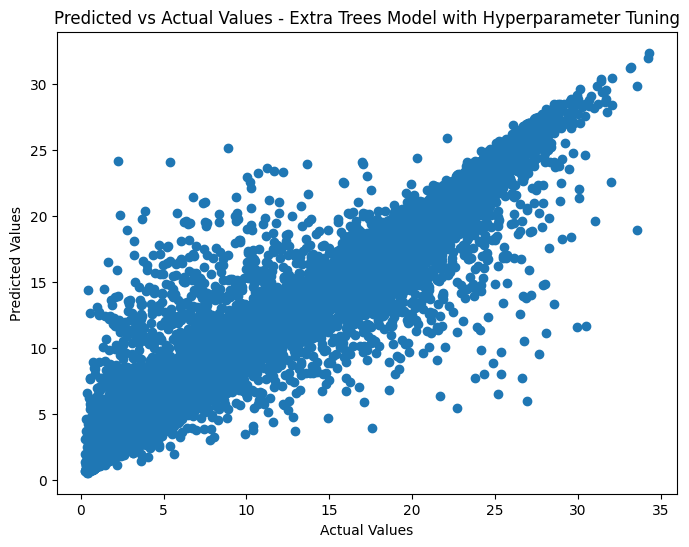

In [ ]:
# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values - Extra Trees Model with Hyperparameter Tuning')
plt.show()

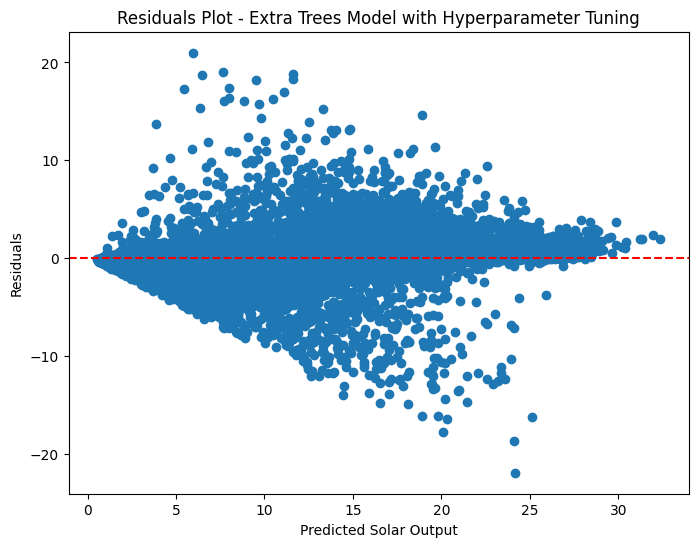

In [ ]:
# Calculate residuals
residuals = y_true - y_pred

# Create a residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Solar Output')
plt.ylabel('Residuals')
plt.title('Residuals Plot - Extra Trees Model with Hyperparameter Tuning')
plt.show()

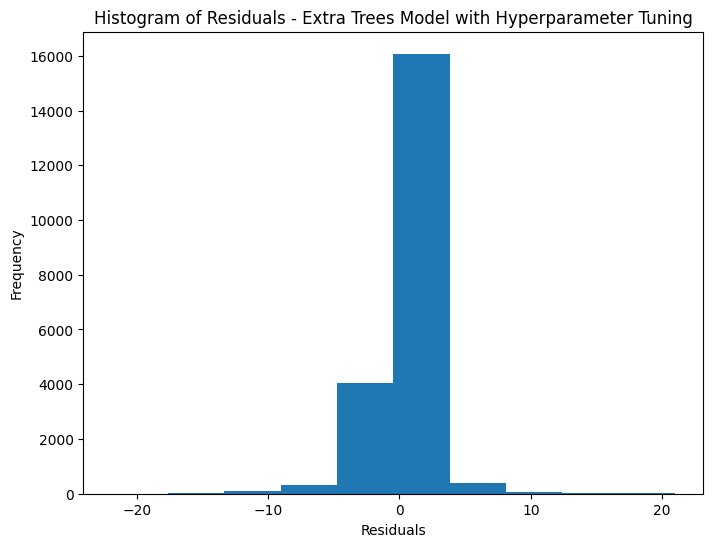

In [ ]:
# Create a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals - Extra Trees Model with Hyperparameter Tuning')
plt.show()

In [ ]:
# Get feature importances
importances = best_model.feature_importances_

# Create a DataFrame with variable names and importances
feature_importances = pd.DataFrame({'Variable': X_train_red.columns, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False).reset_index(drop=True)

In [ ]:
# Display the feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
             Variable  Importance
0         AmbientTemp    0.286404
1            Humidity    0.126196
2              Zenith    0.056525
3             AirTemp    0.056046
4             Azimuth    0.055313
5         AlbedoDaily    0.045477
6            Altitude    0.039923
7        CloudOpacity    0.035445
8        DewpointTemp    0.035197
9   PrecipitableWater    0.033495
10         Wind.Speed    0.031832
11    SurfacePressure    0.030998
12           Pressure    0.030842
13   WindDirection10m    0.025914
14       WindSpeed10m    0.023719
15   RelativeHumidity    0.022203
16        GtiTracking    0.016790
17       GtiFixedTilt    0.014167
18                Ghi    0.013529
19                Ebh    0.012807
20          SnowWater    0.007180


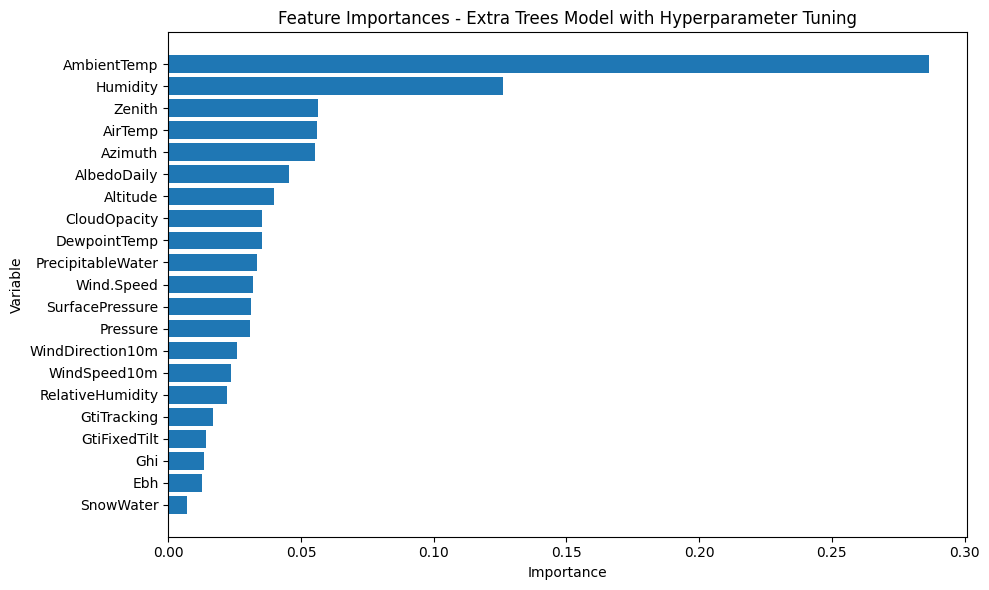

In [ ]:
# Sort the feature importances for plot
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Variable'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Feature Importances - Extra Trees Model with Hyperparameter Tuning')
plt.tight_layout()
plt.show()